In [1]:
import h5py
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

### Preprocessing Part

#### The following class loads and extract the bounding boxes information of the images contained in a given folder. Then it generates data eliminating images with low resolution (parameters can be chosen when invoking the generate_data function)

In [2]:
class SVHN_RegressionSet(object):

    def __init__(self, folder):

        self.folder = folder
        self.file = h5py.File(os.path.join(folder, "digitStruct.mat"), 'r')
        self.FileNames = self.file['digitStruct']['name']
        self.Bbox = self.file['digitStruct']['bbox']
        self.boxes = self.get_boxes()

    def get_boxes(self):
        boxes = []
        for i in range(len(self.FileNames)):
            box = {"filename" : ''.join([chr(k[0]) for k in self.file[self.FileNames[i][0]].value])}
            for k in self.file[self.Bbox[i].item()].keys():
                c = self.file[self.Bbox[i].item()][k]
                if len(c) == 1:
                    box[k] = [c.value[0][0]]
                else:
                    box[k] = [self.file[c.value[j].item()].value[0][0] for j in range(len(c))]
            boxes.append(box)
        return boxes

    def generate_data(self, min_x=64, min_y=48):
        X = []
        y = []
        for b in self.boxes:
            image = cv2.imread(os.path.join(self.folder, b["filename"]))
            if image.shape[0] < min_y or image.shape[1] < min_x:
                continue
            if len(b["label"]) > 5:   #We skip cases with more than 5 digits altogether
                continue
            y1 = np.min(b["top"]) - 1
            y2 = np.max(np.array(b["top"])+np.array(b["height"])) + 1
            x1 = np.min(b["left"]) - 1
            x2 = np.max(np.array(b["left"]) + np.array(b["width"])) + 1
            if y1 < 0: y1=0
            if x1 < 0: x1=0

            y.append(np.array([x1,x2,y1,y2]))    
                
            image = np.dot(image, [[0.2989], [0.5870], [0.1140]])
            mean = np.mean(image, dtype='float32')
            std = np.std(image, dtype='float32')
            if std < 1e-4: std = 1.
            image = (image - mean) / std
            X.append(image)
            
        return X, y

#### Here we use the above class to take data from the train, test and extra directories.

In [ ]:
train_dir = "../SVHN_case/train/"
test_dir = "../SVHN_case/test/"
extra_dir = "../SVHN_case/extra/"

m_x = 32 #128
m_y = 32 #96
data = SVHN_RegressionSet(train_dir)
X_train, y_train = data.generate_data(min_x=m_x, min_y=m_y)

data = SVHN_RegressionSet(test_dir)
X_test, y_test = data.generate_data(min_x=m_x, min_y=m_y)

data = SVHN_RegressionSet(extra_dir)
X_extra, y_extra = data.generate_data(min_x=m_x, min_y=m_y)

#### Use part of the following code in case for data augmentation'

(47, 99, 1)
[ 42.  63.   6.  38.]


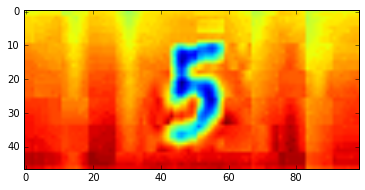

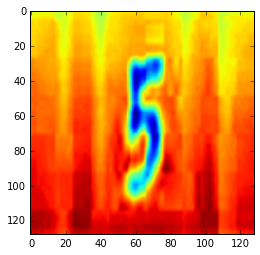

In [47]:

n=0
image = X_test[n]
print image.shape
print y_test[n]
plt.imshow(image[:,:,0])
plt.show()

new_image = cv2.resize(image,(128,128))

plt.imshow(new_image[:,:])
plt.show()


#(h, w) = new_image.shape
#center = (w / 2, h / 2)
#M = cv2.getRotationMatrix2D(center, angle=100, scale=1.0)
#new_new_image = cv2.warpAffine(new_image, M, (w, h))#

#plt.imshow(new_new_image[:,:])
#plt.show()


#### The following function resizes images to a given format and calculates the deformations on the bounding boxes

In [3]:
def normalize_images_and_boxes(images, boxes, width=128, height=128):
    new_images = np.zeros((len(images), height, width),dtype=np.float32)
    new_boxes = np.zeros((len(images), 4))
    for i, image in enumerate(images):
        delta_y = boxes[i][3]- boxes[i][2]
        delta_x = boxes[i][1]- boxes[i][0]
        y_ratio = float(height)/image.shape[0]
        x_ratio = float(width)/image.shape[1]
        
        y1p = int(boxes[i][2] * y_ratio)
        y2p = y1p + int(delta_y * y_ratio)
        
        x1p = int(boxes[i][0] * x_ratio)
        x2p = x1p + int(delta_x * x_ratio)
        #print delta_y, delta_x, boxes[i], y_ratio, x_ratio
        
        
        # This is a wrong transformation
        new_boxes[i] = np.array([x1p, x2p, y1p, y2p])
        new_images[i] = cv2.resize(image,(height, width))
    return new_images, new_boxes
        

#### Here we test the above methods

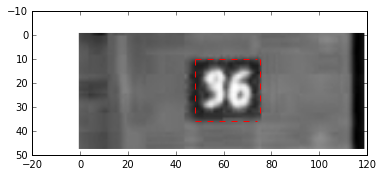

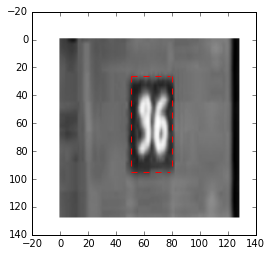

In [84]:
n = 79

plt.imshow(X_test[n][:,:,0],cmap="Greys_r")
plt.plot(np.arange(y_test[n][0], y_test[n][1]),np.ones(y_test[n][1]-y_test[n][0])*y_test[n][3], "r--")
plt.plot(np.arange(y_test[n][0], y_test[n][1]),np.ones(y_test[n][1]-y_test[n][0])*y_test[n][2], "r--")
plt.plot(np.ones(y_test[n][3] - y_test[n][2])*y_test[n][0],np.arange(y_test[n][2], y_test[n][3]), "r--")
plt.plot(np.ones(y_test[n][3] - y_test[n][2])*y_test[n][1],np.arange(y_test[n][2], y_test[n][3]), "r--")
plt.show()

plt.imshow(X_test_new[n,:,:], cmap="Greys_r")
plt.plot(np.arange(y_test_new[n,0], y_test_new[n,1]),np.ones(y_test_new[n,1]-y_test_new[n,0])*y_test_new[n,3], "r--")
plt.plot(np.arange(y_test_new[n,0], y_test_new[n,1]),np.ones(y_test_new[n,1]-y_test_new[n,0])*y_test_new[n,2], "r--")
plt.plot(np.ones(y_test_new[n,3] - y_test_new[n,2])*y_test_new[n,0],np.arange(y_test_new[n,2], y_test_new[n,3]), "r--")
plt.plot(np.ones(y_test_new[n,3] - y_test_new[n,2])*y_test_new[n,1],np.arange(y_test_new[n,2], y_test_new[n,3]), "r--")
plt.show()

#### Here we use pickle to save the preprocessed data for future usage

In [ ]:
X_train_n, y_train_n = normalize_images_and_boxes(X_train, y_train)
X_test_n, y_test_n = normalize_images_and_boxes(X_test, y_test)
X_extra_n, y_extra_n = normalize_images_and_boxes(X_extra, y_extra)


from six.moves import cPickle as pickle

f = open("../SVHN_case/SVHN_Regression.pickle", 'wb')
save = {
        'X_train': X_train_n,
        'y_train': y_train_n,
        'X_extra': X_extra_n,
        'y_extra': y_extra_n,
        'X_test': X_test_n,
        'y_test': y_test_n,
    }
pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [5]:
train_dir = "../SVHN_case/train/"

m_x = 32 #128
m_y = 32 #96
data = SVHN_RegressionSet(train_dir)
X_train, y_train = data.generate_data(min_x=m_x, min_y=m_y)
X_train, y_train = normalize_images_and_boxes(X_train, y_train)
from six.moves import cPickle as pickle

f = open("../SVHN_case/SVHN_Regression_train.pickle", 'wb')
save = {
        'X_train': X_train,
        'y_train': y_train
    }
pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()


In [6]:
test_dir = "../SVHN_case/test/"

m_x = 32 #128
m_y = 32 #96
data = SVHN_RegressionSet(test_dir)
X_test, y_test = data.generate_data(min_x=m_x, min_y=m_y)
X_test, y_test = normalize_images_and_boxes(X_test, y_test)
from six.moves import cPickle as pickle

f = open("../SVHN_case/SVHN_Regression_test.pickle", 'wb')
save = {
        'X_test': X_test,
        'y_test': y_test
    }
pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()


#### The following extra images are many and heavy in memory content. We suggest to pickle them separately

In [5]:
extra_dir = "../SVHN_case/extra/"

m_x = 32 #128
m_y = 32 #96
data = SVHN_RegressionSet(extra_dir)
X_extra, y_extra = data.generate_data(min_x=m_x, min_y=m_y)
X_extra, y_extra = normalize_images_and_boxes(X_extra, y_extra)
from six.moves import cPickle as pickle

f = open("../SVHN_case/SVHN_Regression_extra.pickle", 'wb')
save = {
        'X_extra': X_extra,
        'y_extra': y_extra
    }
pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()


### Machine Learning Part

In [2]:
from six.moves import cPickle as pickle
pickle_file = '../SVHN_case/SVHN_Regression_train.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  X_train = save['X_train']
  y_train = save['y_train']
  del save  # hint to help gc free up memory
    
    
  print('Training set', X_train.shape, y_train.shape)

('Training set', (25933, 128, 128), (25933, 4))


In [3]:
from six.moves import cPickle as pickle
pickle_file = '../SVHN_case/SVHN_Regression_test.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  X_test = save['X_test']
  y_test = save['y_test']
  del save  # hint to help gc free up memory
    
    
  print('Training set', X_test.shape, y_test.shape)

('Training set', (11767, 128, 128), (11767, 4))


In [4]:
import tensorflow as tf
image_size = 128
num_channels = 1 
num_epochs = 10000

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden = 64
drop_out_prob = 0.5

graph = tf.Graph()

with graph.as_default():
    
# Input data.
    x = tf.placeholder(tf.float32, shape=(None, image_size, image_size, 1))
    y = tf.placeholder(tf.float32, shape=(None, 4))
    #tf_valid_dataset = tf.constant(valid_dataset)
    #tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    W_c1 = tf.truncated_normal(shape=[patch_size, patch_size, num_channels, depth1], stddev=0.1)
    b_c1 = tf.Variable(tf.constant(1.0, shape=[depth1]))
    W_c2 = tf.truncated_normal(shape=[patch_size, patch_size, depth1, depth2], stddev=0.1)
    b_c2 = tf.Variable(tf.constant(1.0, shape=[depth2]))
    W_c3 = tf.truncated_normal(shape=[patch_size, patch_size, depth2, depth3], stddev=0.1)
    b_c3 = tf.Variable(tf.constant(1.0, shape=[depth3]))
  
    num_var = depth3/64 * image_size * image_size
    W_fc = tf.truncated_normal(shape=[num_var, num_hidden], stddev=0.1)
    b_fc = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    #W_fcfinal = [tf.truncated_normal(shape=[num_hidden, 4], stddev=0.1) for i in range(4)]
    #b_fcfinal = [tf.Variable(tf.constant(1.0, shape=[4])) for i in range(4)]
    
    W_fcfinal = tf.truncated_normal(shape=[num_hidden, 4], stddev=0.1)
    b_fcfinal = tf.Variable(tf.constant(1.0, shape=[4]))
  
  
    # Model.
    def model(data, keep_prob):
      #print data.shape
      conv = tf.nn.conv2d(data, W_c1, [1,1,1,1], 'SAME', name='C1')
      hidden = tf.nn.relu(conv + b_c1)
      #print hidden.get_shape()
      lrn = tf.nn.local_response_normalization(hidden)
      sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')
        
        
      #print sub.get_shape()
      conv = tf.nn.conv2d(sub, W_c2, [1,1,1,1], padding='SAME', name='C3')
      hidden = tf.nn.relu(conv + b_c2)
      #print hidden.get_shape()
      lrn = tf.nn.local_response_normalization(hidden)
      sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S4')
        
      conv = tf.nn.conv2d(sub, W_c3, [1,1,1,1], padding='SAME', name='C5')
      hidden = tf.nn.relu(conv + b_c3)
      #print hidden.get_shape()
      lrn = tf.nn.local_response_normalization(hidden)
      sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S6')  
        
        
      #print sub.get_shape()
      shape = sub.get_shape()

      sub2_flat = tf.reshape(sub, [-1, int(shape[1]*shape[2]*shape[3])])
      #print sub2_flat.get_shape()
      h_fc = tf.nn.relu(tf.matmul(sub2_flat, W_fc) + b_fc)
      h_fc_drop = tf.nn.dropout(h_fc, keep_prob)
    
      #return [tf.matmul(h_fc_drop, W_fcfinal[i]) + b_fcfinal[i] for i in range(4)]
      return tf.matmul(h_fc_drop, W_fcfinal) + b_fcfinal
    
    
  
  # Training computation.
    out = model(x, drop_out_prob)
    loss = tf.reduce_mean(tf.nn.l2_loss(out-y, name=None))
    
    
  # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
    def next_batch(X, y, batch_init, length=batch_size):
        if (batch_init + 1) * length <= len(y):
            init = batch_init * length
            fin = (batch_init + 1) * length
            batch_init += 1
            return (X[init: fin], y[init: fin]), batch_init
        else:
            init = batch_init * length
            batch_init = 0
            return (X[init:], y[init:]) , batch_init
    
    #train_prediction = tf.pack([model(x, 1.0)[i] for i in range(4)])
    
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()  
    batch_init = 0
    for step in range(num_epochs):
        batch, batch_init = next_batch(X_train, y_train, batch_init)
        feed_dict = {x : batch[0].reshape(-1, image_size, image_size, 1), y : batch[1]}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
   
    
        if (step % 100 == 0): 
            print('Minibatch loss at step %d: %f' % (step, l))
    #  print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))
     # print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels[:,1:6]))
  #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
  #save_path = saver.save(session, "CNN_multi.ckpt")
  #print("Model saved in file: %s" % save_path)

Minibatch loss at step 0: 640907.875000
Minibatch loss at step 100: 645709.812500
Minibatch loss at step 200: 635211.062500
Minibatch loss at step 300: 623351.437500
Minibatch loss at step 400: 642912.000000
Minibatch loss at step 500: 607471.375000
Minibatch loss at step 600: 578384.437500
Minibatch loss at step 700: 616601.437500
Minibatch loss at step 800: 625659.750000
Minibatch loss at step 900: 632269.937500
Minibatch loss at step 1000: 578491.812500
Minibatch loss at step 1100: 643108.062500
Minibatch loss at step 1200: 628884.312500
Minibatch loss at step 1300: 596850.125000
Minibatch loss at step 1400: 640260.000000
Minibatch loss at step 1500: 565943.625000
Minibatch loss at step 1600: 613318.312500
Minibatch loss at step 1700: 579980.625000
Minibatch loss at step 1800: 571423.562500
Minibatch loss at step 1900: 555855.187500
Minibatch loss at step 2000: 559418.562500
Minibatch loss at step 2100: 599787.750000
Minibatch loss at step 2200: 579263.312500
Minibatch loss at step 